In [ ]:
import os
import glob
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector, Masking, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DATA_PATH = '/content/drive/My Drive/table_tennis_ball_trajectories'
SUBDIRECTORIES_TO_PROCESS = [
    "MN5008_training_data",
    "MN5008_grid_search"
    # Add more directories as needed, e.g., from your dataset structure:
    # "303A_accuracy_distance",
    # "MN5008_training_data_with_outlier",
    # "MN5008_grid_search_with_outlier",
    # ... ensure these contain relevant trajectory data in the expected format
]
# Model & Training Parameters
N_LSTM_UNITS = 128
N_DENSE_UNITS = 128 # For the initial Dense layer
EPOCHS = 50 # Increase for better training, consider EarlyStopping
BATCH_SIZE = 128
TEST_SPLIT_RATIO = 0.2
RANDOM_STATE = 42
PADDING_VALUE = 0.0 # Value used for padding sequences


In [ ]:
# ## 3. Data Loading Function

# %%
def load_trajectory_data_from_hdf5(file_path):
    """
    Loads launch parameters and position trajectories from a single HDF5 file.
    Launch parameters are expected to be [azimuth, altitude, wheel1, wheel2, wheel3].
    Positions are sequences of [x, y, z] coordinates.
    """
    launch_params_list = []
    trajectories_list = []

    try:
        with h5py.File(file_path, 'r') as hf:
            if 'originals' in hf:
                for trajectory_group_name in hf['originals'].keys():
                    trajectory_group = hf['originals'][trajectory_group_name]
                    if 'launch_param' in trajectory_group and 'positions' in trajectory_group:
                        launch_param = trajectory_group['launch_param'][:]
                        positions = trajectory_group['positions'][:]

                        # Basic validation of data shapes
                        if launch_param.shape == (5,) and len(positions.shape) == 2 and positions.shape[1] == 3 and positions.shape[0] > 1:
                            launch_params_list.append(launch_param)
                            trajectories_list.append(positions)
                        else:
                            print(f"  Skipping group {trajectory_group_name} in {file_path} due to unexpected data shape: LP={launch_param.shape}, Pos={positions.shape}")
                    # else:
                        # print(f"  Skipping group {trajectory_group_name} in {file_path} (missing launch_param or positions)")
            # else:
                # print(f"  'originals' group not found in {file_path}")

    except Exception as e:
        print(f"Error reading or processing {file_path}: {e}")

    return launch_params_list, trajectories_list




In [ ]:
# ## 4. Process All Specified Data Files


all_launch_params = []
all_trajectories = []
total_files_processed = 0

print("Starting data loading process...")
for subdir_name in SUBDIRECTORIES_TO_PROCESS:
    current_dir_path = os.path.join(BASE_DATA_PATH, subdir_name)
    if not os.path.isdir(current_dir_path):
        print(f"Warning: Subdirectory not found: {current_dir_path}")
        continue

    print(f"\nProcessing subdirectory: {current_dir_path}")
    hdf5_files = glob.glob(os.path.join(current_dir_path, "*.hdf5"))
    print(f"Found {len(hdf5_files)} HDF5 files.")

    for hdf5_file_path in hdf5_files:
        # print(f"Loading data from: {hdf5_file_path}")
        lp_list, traj_list = load_trajectory_data_from_hdf5(hdf5_file_path)
        all_launch_params.extend(lp_list)
        all_trajectories.extend(traj_list)
        total_files_processed +=1

print(f"\nFinished data loading.")
print(f"Total HDF5 files processed: {total_files_processed}")
print(f"Total trajectories loaded: {len(all_trajectories)}")

if all_trajectories:
    print(f"Example launch_param: {all_launch_params[0]}")
    print(f"Example trajectory shape: {all_trajectories[0].shape}")
else:
    print("No trajectories loaded. Please check BASE_DATA_PATH and SUBDIRECTORIES_TO_PROCESS.")
    # Exit if no data, or handle appropriately
    exit()

Starting data loading process...

Processing subdirectory: /content/drive/My Drive/table_tennis_ball_trajectories/MN5008_training_data
Found 4 HDF5 files.

Processing subdirectory: /content/drive/My Drive/table_tennis_ball_trajectories/MN5008_grid_search
Found 14 HDF5 files.

Finished data loading.
Total HDF5 files processed: 18
Total trajectories loaded: 10204
Example launch_param: [3.0e-01 2.0e-01 1.2e+03 1.2e+03 1.2e+03]
Example trajectory shape: (164, 3)


In [ ]:

# ## 5. Data Preprocessing


# ### 5.1. Convert to NumPy Arrays & Initial Checks
# `all_launch_params` and `all_trajectories` should be populated from your data loading (Section 4).
# %%
if not 'all_launch_params' in locals() or not 'all_trajectories' in locals() or \
   not all_launch_params or not all_trajectories:
    print("ERROR: Data not loaded. 'all_launch_params' or 'all_trajectories' is missing or empty.")
    print("Please ensure Section 4 (data loading) has run successfully and populated these variables.")
    # exit() # Exit or handle error appropriately
else:
    print(f"Data loaded from Section 4: Found {len(all_launch_params)} launch parameter sets and {len(all_trajectories)} trajectories.")

# Convert launch parameters to a NumPy array
# Your loaded launch_params might already be numpy arrays or lists of numbers.
# Ensuring they are float32 numpy arrays.
try:
    X_raw = np.array(all_launch_params, dtype='float32')
except ValueError as e:
    print(f"ERROR converting all_launch_params to NumPy array: {e}")
    print("Please check the structure of your launch parameters. They should be lists/arrays of numbers.")
    # For debugging, print the first few elements:
    # for i in range(min(5, len(all_launch_params))):
    # print(f"Sample launch_param {i}: {all_launch_params[i]}")
    # exit()

# Trajectories are of variable length; they will be kept as a list of NumPy arrays for now,
# and then padded. Each element in all_trajectories should be a NumPy array of shape (timesteps, features).
# Let's ensure each trajectory is a NumPy array.
# Your load_trajectory_data_from_hdf5 might already return them as numpy arrays.
# If not, this is a good place to convert them.
processed_trajectories = []
for i, traj in enumerate(all_trajectories):
    if isinstance(traj, np.ndarray):
        if traj.ndim == 2 and traj.shape[1] == 3: # Assuming 3D coordinates (x,y,z)
            processed_trajectories.append(traj.astype('float32'))
        else:
            print(f"WARNING: Trajectory at index {i} is a NumPy array but has unexpected shape: {traj.shape}. Expected (timesteps, 3). Skipping.")
            # Optionally, you could try to reshape or discard this trajectory
    elif isinstance(traj, list):
        try:
            traj_np = np.array(traj, dtype='float32')
            if traj_np.ndim == 2 and traj_np.shape[1] == 3:
                processed_trajectories.append(traj_np)
            else:
                print(f"WARNING: Trajectory at index {i} (converted from list) has unexpected shape: {traj_np.shape}. Expected (timesteps, 3). Skipping.")
        except Exception as e:
            print(f"WARNING: Could not convert trajectory at index {i} (list) to NumPy array: {e}. Skipping.")
    else:
        print(f"WARNING: Trajectory at index {i} has unexpected type: {type(traj)}. Skipping.")

all_trajectories = processed_trajectories # Update all_trajectories with processed ones

if not all_trajectories:
    print("ERROR: No valid trajectories remaining after processing/type conversion. Please check trajectory data format.")
    # exit()

print(f"Raw X (launch parameters) shape: {X_raw.shape if 'X_raw' in locals() else 'Not defined due to error'}")
if 'X_raw' in locals() and X_raw.size == 0:
    print("ERROR: X_raw is empty. Problem with converting launch_params.")
    # exit()
if not all_trajectories: # Double check after processing
     print("ERROR: all_trajectories list is empty after processing step 5.1.")
     # exit()


# ### 5.2. Pad Trajectory Sequences (Target Y) & Check Max Length
# (The rest of your Section 5.2 and onwards would follow here)
# For example, starting with determining max_seq_length:
# %%
max_seq_length = 0
if all_trajectories:
    for i, seq in enumerate(all_trajectories):
        # Ensure sequence is a list of lists or numpy array before converting/checking
        if isinstance(seq, list): # Convert list of lists to numpy array
            current_seq = np.array(seq, dtype='float32')
        elif isinstance(seq, np.ndarray):
            current_seq = seq
        else:
            print(f"ERROR: Trajectory at index {i} has unexpected type: {type(seq)}")
            # all_trajectories[i] = None # Mark for removal or handle
            continue

        if not current_seq.ndim == 2 or not current_seq.shape[1] == 3: # Assuming 3D coordinates (x,y,z)
            print(f"ERROR: Trajectory at index {i} has unexpected format/shape: {current_seq.shape if hasattr(current_seq, 'shape') else 'N/A'}")
            # all_trajectories[i] = None
            continue
        if len(current_seq) > max_seq_length:
            max_seq_length = len(current_seq)
    # all_trajectories = [np.array(s, dtype='float32') for s in all_trajectories if s is not None and np.array(s).ndim == 2 and np.array(s).shape[1] == 3] # Filter and ensure type
else:
    print("ERROR: all_trajectories is empty.")
    # exit()

print(f"Maximum trajectory sequence length (timesteps): {max_seq_length}")
if max_seq_length == 0 and all_trajectories:
    print("ERROR: max_seq_length is 0, but trajectories were loaded. Check trajectory data.")
    # exit()
elif max_seq_length > 1500:
    print(f"WARNING: max_seq_length is very large ({max_seq_length}). This will require significant memory for LSTMs.")

PADDING_VALUE = 0.0
# Ensure all_trajectories contains numpy arrays before padding
valid_trajectories = []
for i, seq_data in enumerate(all_trajectories):
    try:
        arr = np.array(seq_data, dtype='float32')
        if arr.ndim == 2 and arr.shape[1] == 3: # Assuming 3 features (x,y,z)
            valid_trajectories.append(arr)
        else:
            print(f"Warning: Skipping trajectory {i} with unexpected shape: {arr.shape}")
    except Exception as e:
        print(f"Warning: Could not convert trajectory {i} to numpy array: {e}")

if not valid_trajectories:
    print("ERROR: No valid trajectories to pad after filtering.")
    # exit()

y_padded = pad_sequences(valid_trajectories, maxlen=max_seq_length, padding='post', dtype='float32', value=PADDING_VALUE)

if y_padded.size == 0:
    print("ERROR: y_padded is empty. Problem with trajectory padding.")
    # exit()
print(f"Padded Y (trajectories) shape: {y_padded.shape}")

# ### 5.2a. Data Validation (NaNs, Infs)
# %%
if np.any(np.isnan(X_raw)): print("ERROR: NaNs found in X_raw!")
if np.any(np.isinf(X_raw)): print("ERROR: Infs found in X_raw!")
if np.any(np.isnan(y_padded)): print("ERROR: NaNs found in y_padded!")
if np.any(np.isinf(y_padded)): print("ERROR: Infs found in y_padded!")
print("Data validation for NaNs/Infs complete.")

# ### 5.3. Train-Test Split
# %%
TEST_SPLIT_RATIO = 0.2
RANDOM_STATE = 42
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_padded, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE
)
print(f"X_train_raw shape: {X_train_raw.shape}, y_train shape: {y_train.shape}")
print(f"X_test_raw shape: {X_test_raw.shape}, y_test shape: {y_test.shape}")

# ### 5.4. Feature Scaling for Launch Parameters (Input X)
# %%
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
print(f"Scaled X_train shape: {X_train.shape}")
print(f"Scaled X_test shape: {X_test.shape}")


# ### 5.5. (DEBUGGING STEP) Try with a VERY SMALL Subset of Data
# %%
DEBUG_SUBSET_SIZE = 128
if X_train.shape[0] > DEBUG_SUBSET_SIZE:
    print(f"\n--- DEBUGGING: Using a subset of {DEBUG_SUBSET_SIZE} samples for initial training test ---")
    X_train_debug = X_train[:DEBUG_SUBSET_SIZE]
    y_train_debug = y_train[:DEBUG_SUBSET_SIZE]
else:
    print("\n--- DEBUGGING: Dataset is smaller than DEBUG_SUBSET_SIZE, using full training set for debug ---")
    X_train_debug = X_train
    y_train_debug = y_train
print(f"X_train_debug shape: {X_train_debug.shape}, y_train_debug shape: {y_train_debug.shape}")


# ## 5.X. TensorFlow GPU Check
# %%
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0]}")
    except RuntimeError as e:
        print(f"GPU Error: {e}")
else:
    print("No GPU found by TensorFlow. Training will be on CPU.")

Data loaded from Section 4: Found 10204 launch parameter sets and 10204 trajectories.
Raw X (launch parameters) shape: (10204, 5)
Maximum trajectory sequence length (timesteps): 629
Padded Y (trajectories) shape: (10204, 629, 3)
Data validation for NaNs/Infs complete.
X_train_raw shape: (8163, 5), y_train shape: (8163, 629, 3)
X_test_raw shape: (2041, 5), y_test shape: (2041, 629, 3)
Scaled X_train shape: (8163, 5)
Scaled X_test shape: (2041, 5)

--- DEBUGGING: Using a subset of 128 samples for initial training test ---
X_train_debug shape: (128, 5), y_train_debug shape: (128, 629, 3)
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:

# ## 6. Build the LSTM Model (Enhanced)
# %%
# Model & Training Parameters
N_LSTM_UNITS = 128    # Original: 128. Tunable: 64, 128, 256
N_DENSE_UNITS = 128   # Original: 128. Tunable: 64, 128, 256
DROPOUT_RATE = 0.2    # Tunable: 0.1 - 0.5. Added for regularization.

# For full training, increase EPOCHS and adjust BATCH_SIZE as needed
EPOCHS_FULL = 100        # Example for full run
BATCH_SIZE_FULL = 64     # Example for full run

num_launch_features = X_train.shape[1]
timesteps = y_train.shape[1]  # This is max_seq_length
num_output_features = y_train.shape[2]

model = Sequential([
    Dense(N_DENSE_UNITS, activation='relu', input_shape=(num_launch_features,)),
    Dropout(DROPOUT_RATE),  # Added Dropout
    RepeatVector(timesteps),
    LSTM(N_LSTM_UNITS, return_sequences=True, activation='tanh'),
    Dropout(DROPOUT_RATE),  # Added Dropout
    LSTM(N_LSTM_UNITS, return_sequences=True, activation='tanh'), # Second LSTM layer (original)
    Dropout(DROPOUT_RATE),  # Added Dropout
    # Optional: Add a third LSTM layer for more complexity if needed
    # LSTM(N_LSTM_UNITS // 2, return_sequences=True, activation='tanh'),
    # Dropout(DROPOUT_RATE),
    TimeDistributed(Dense(num_output_features)) # Outputs (x,y,z) at each timestep
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Tunable: 0.0001 - 0.005

model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 629, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 629, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 629, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 629, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 629, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 629, 3)         │           387 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,323 (1.01 MB)

 Trainable params: 264,323 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# ## 7. Train the Model (Revised with Debugging Steps)
# %%
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.0001) # Increased patience

# --- Training on the debug-subset data ---
DEBUG_EPOCHS = 10 # Increased slightly for debug, use more for full training
DEBUG_BATCH_SIZE = 32

# --- Parameters for FULL training (activate these lines when ready) ---
USE_FULL_DATASET = True # Set to True to use full dataset
EPOCHS = 100            # Target epochs for full training
BATCH_SIZE = 64         # Batch size for full training

X_train_to_use = X_train if USE_FULL_DATASET else X_train_debug
y_train_to_use = y_train if USE_FULL_DATASET else y_train_debug
epochs_to_run = EPOCHS if USE_FULL_DATASET else DEBUG_EPOCHS
batch_size_to_run = BATCH_SIZE if USE_FULL_DATASET else DEBUG_BATCH_SIZE
validation_data_for_fit = (X_test, y_test)
 # Always validate on full test set

# For now, continuing with debug dataset as per original structure
epochs_to_run = EPOCHS
batch_size_to_run = BATCH_SIZE
# For debug, using a validation split from the debug training data:
validation_split_to_use = 0.2
validation_data_for_fit = None # Will use validation_split with debug data

# If you want to use a subset of X_test/y_test for validation during debug:
val_debug_subset_size = DEBUG_SUBSET_SIZE // 5
X_test_debug_val = X_test[:val_debug_subset_size]
y_test_debug_val = y_test[:val_debug_subset_size]
#validation_data_for_fit = (X_test_debug_val, y_test_debug_val)
#validation_split_to_use = None # Then don't use validation_split


print(f"\n--- STARTING MODEL TRAINING ---")
print(f"Training with {X_train_to_use.shape[0]} samples for {epochs_to_run} epochs with batch size {batch_size_to_run}.")
print(f"Target timesteps (max_seq_length): {timesteps}")

history = None # Initialize history
try:
    history = model.fit(
        X_train_to_use, y_train_to_use,
        epochs=epochs_to_run,
        batch_size=batch_size_to_run,
        validation_split=validation_split_to_use, # Uses a portion of training data for validation
        validation_data=validation_data_for_fit, # Or provide a separate validation set
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    print("Model training finished.")

except Exception as e:
    print(f"\nERROR DURING model.fit(): {e}")
    import traceback
    traceback.print_exc()



--- STARTING MODEL TRAINING ---
Training with 8163 samples for 100 epochs with batch size 64.
Target timesteps (max_seq_length): 629
Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 54s 297ms/step - loss: 0.4436 - mae: 0.3847 - root_mean_squared_error: 0.6659 - val_loss: 0.3703 - val_mae: 0.3002 - val_root_mean_squared_error: 0.6085 - learning_rate: 0.0010
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - loss: 0.3778 - mae: 0.3448 - root_mean_squared_error: 0.6146 - val_loss: 0.4387 - val_mae: 0.3984 - val_root_mean_squared_error: 0.6623 - learning_rate: 0.0010
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - loss: 0.4009 - mae: 0.3665 - root_mean_squared_error: 0.6329 - val_loss: 1.1702 - val_mae: 0.6879 - val_root_mean_squared_error: 1.0818 - learning_rate: 0.0010
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - loss: 0.4833 - mae: 0.3995 - root_mean_squared_error: 0.6935 - val_loss: 0.4230 - val_mae: 0.3802 - val_root_mean_squared_error: 0.6504 - learning_rate: 0


Evaluating model on the full test set:
Test Mean Squared Error (MSE): 0.0350
Test Mean Absolute Error (MAE): 0.0395
Test Root Mean Squared Error (RMSE): 0.1871


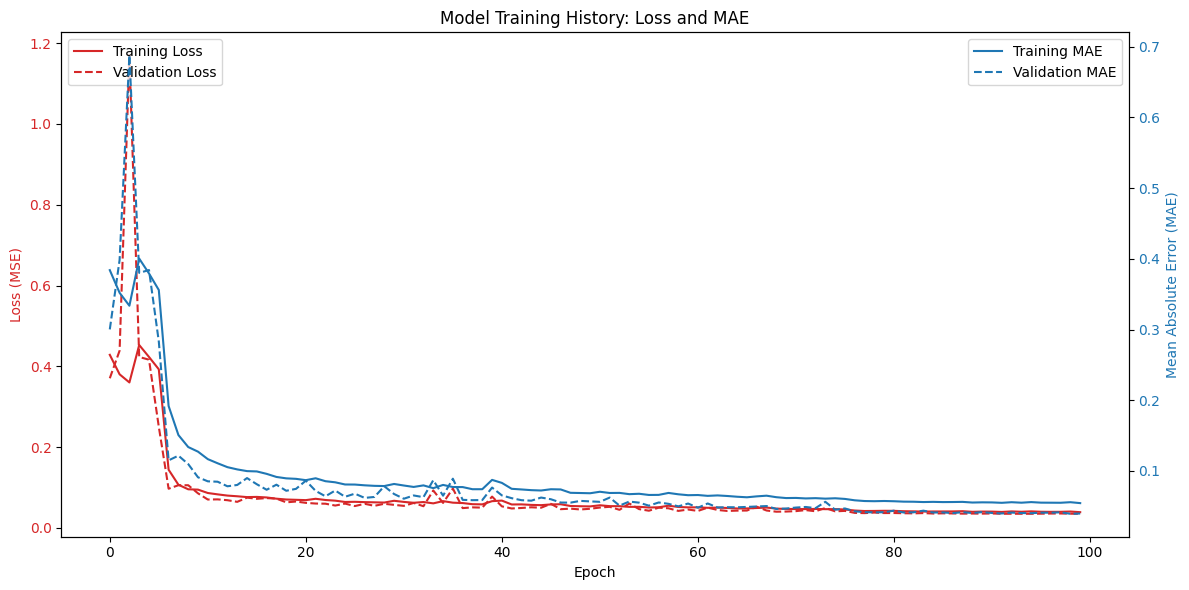

In [ ]:


# ## 8. Evaluate the Model
# %%
if history: # Check if training actually ran
    print("\nEvaluating model on the full test set:")
    loss, mae, rmse = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Mean Squared Error (MSE): {loss:.4f}")
    print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")
else:
    print("Skipping evaluation as model training did not complete.")

# ### 8.1. Plot Training History
# %%
if history and history.history: # Check if history object has data
    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)', color=color)
    if 'loss' in history.history and 'val_loss' in history.history:
        ax1.plot(history.history['loss'], color=color, linestyle='-', label='Training Loss')
        ax1.plot(history.history['val_loss'], color=color, linestyle='--', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.set_title('Model Training History: Loss and MAE')

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Mean Absolute Error (MAE)', color=color)
    if 'mae' in history.history and 'val_mae' in history.history:
        ax2.plot(history.history['mae'], color=color, linestyle='-', label='Training MAE')
        ax2.plot(history.history['val_mae'], color=color, linestyle='--', label='Validation MAE')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.show()
else:
    print("No training history to plot (model.fit might have been skipped, failed, or no validation data).")





Making predictions on a few test samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


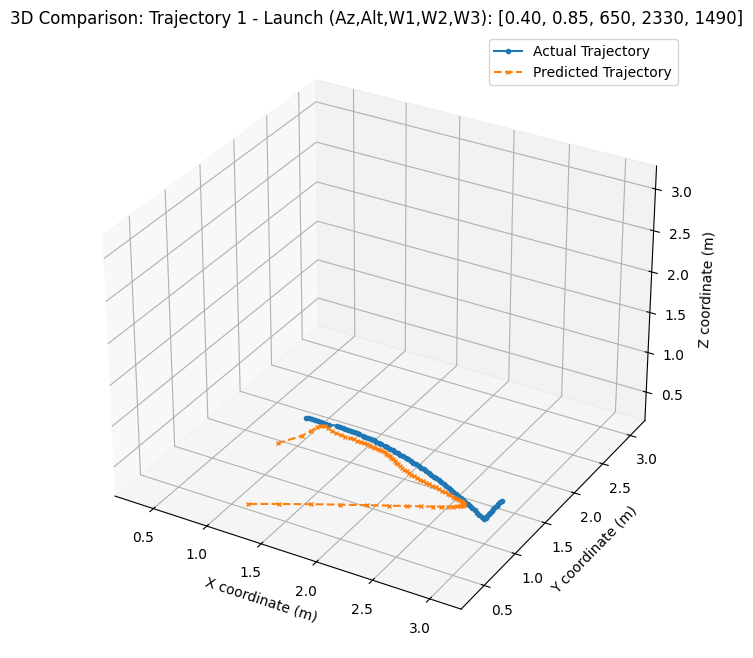

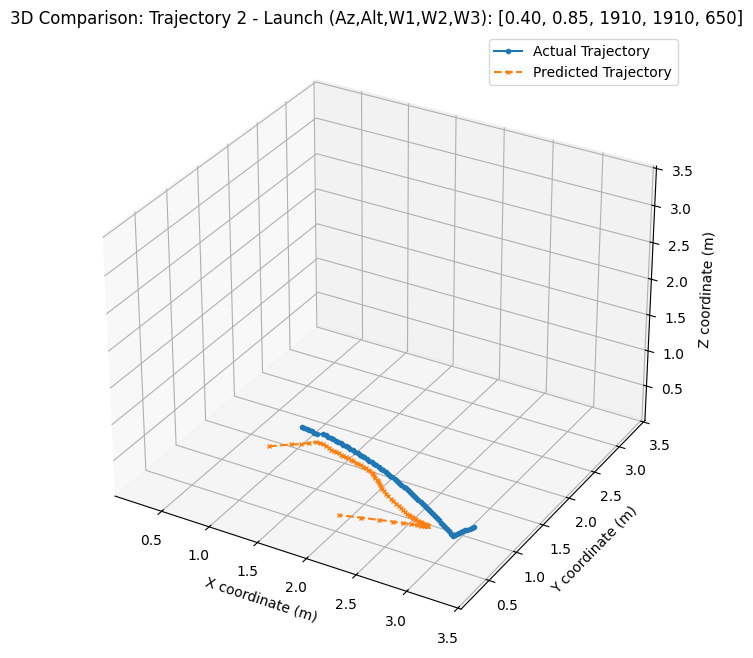

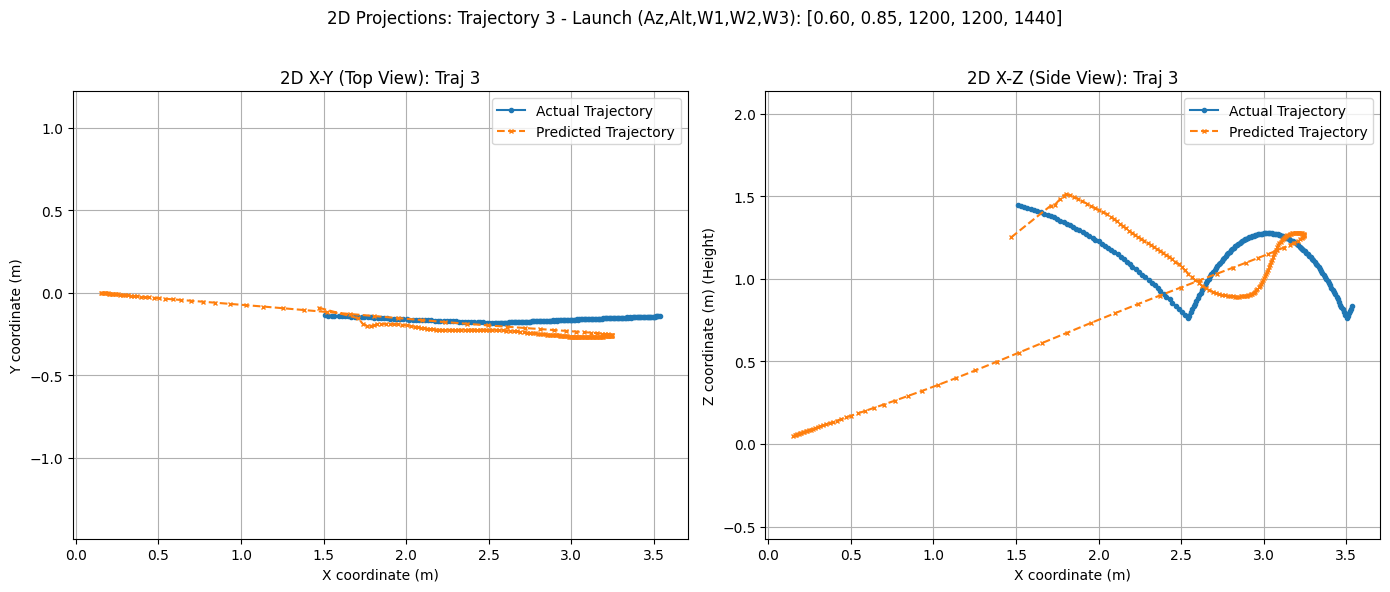

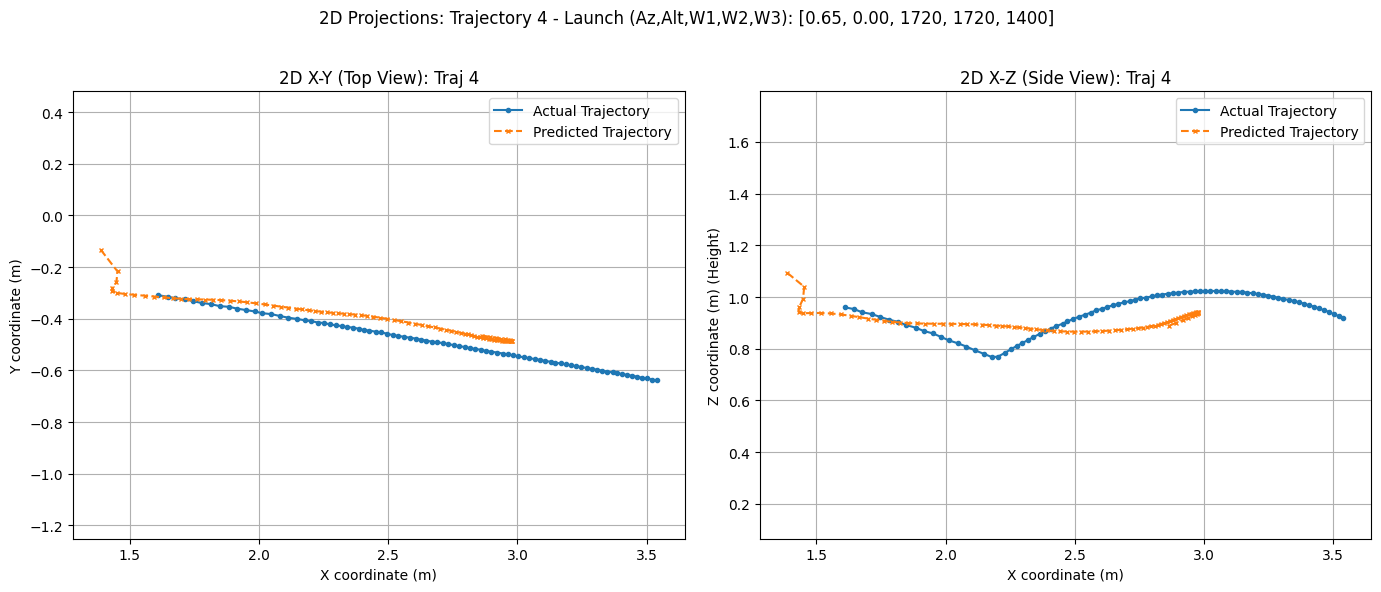

In [ ]:
# ## 9. Make Predictions and Visualize Trajectories (2D and 3D)
# The predictions are made on a subset of the **test set** (`X_test`).
# %%
if history: # Only predict if model was trained
    print("\nMaking predictions on a few test samples...")
    num_visualize = 4 # We will plot 4 trajectories: 2 in 3D, 2 in 2D

    # Ensure we don't try to visualize more samples than available in X_test
    num_visualize = min(num_visualize, X_test.shape[0])

    if num_visualize > 0:
        predictions = model.predict(X_test[:num_visualize])
        X_test_unscaled_viz = scaler.inverse_transform(X_test[:num_visualize]) # Unscale for interpretable parameters

        for i in range(num_visualize):
            actual_traj = y_test[i]
            predicted_traj = predictions[i]
            launch_params_current = X_test_unscaled_viz[i]

            # Determine actual length before padding
            # This assumes PADDING_VALUE (0.0) is not a valid coordinate component for x, y, AND z simultaneously
            # A more robust way for PADDING_VALUE = 0.0:
            # Check if all elements in the last dimension (coordinates) are PADDING_VALUE
            non_padding_indices = np.where(np.any(actual_traj != PADDING_VALUE, axis=1))[0]
            if len(non_padding_indices) > 0:
                actual_len = non_padding_indices[-1] + 1
            else: # Trajectory might be all padding (empty or very short)
                actual_len = 0

            # For predicted trajectory, we can plot up to the same actual_len for comparison
            # or let it plot the full max_seq_length to see if it learns to output padding.

            title_str_base = (f'Trajectory {i+1} - Launch (Az,Alt,W1,W2,W3): '
                             f'[{launch_params_current[0]:.2f}, {launch_params_current[1]:.2f}, '
                             f'{launch_params_current[2]:.0f}, {launch_params_current[3]:.0f}, {launch_params_current[4]:.0f}]')

            if i < num_visualize // 2: # First half: 3D plots
                fig = plt.figure(figsize=(10, 8))
                ax = fig.add_subplot(111, projection='3d')

                ax.plot(actual_traj[:actual_len, 0], actual_traj[:actual_len, 1], actual_traj[:actual_len, 2],
                        label='Actual Trajectory', marker='o', linestyle='-', markersize=3)
                ax.plot(predicted_traj[:actual_len, 0], predicted_traj[:actual_len, 1], predicted_traj[:actual_len, 2],
                        label='Predicted Trajectory', marker='x', linestyle='--', markersize=3)

                ax.set_xlabel('X coordinate (m)')
                ax.set_ylabel('Y coordinate (m)')
                ax.set_zlabel('Z coordinate (m)')
                ax.set_title(f'3D Comparison: {title_str_base}')
                ax.legend()
                # Optional: Set consistent axis limits if needed
                common_min = min(actual_traj[:actual_len].min(), predicted_traj[:actual_len].min())
                common_max = max(actual_traj[:actual_len].max(), predicted_traj[:actual_len].max())
                ax.set_xlim([common_min, common_max])
                ax.set_ylim([common_min, common_max])
                ax.set_zlim([common_min, common_max])


            else: # Second half: 2D plots (e.g., X-Z projection or "side view")
                fig, axs = plt.subplots(1, 2, figsize=(14, 6)) # Two 2D views: X-Y and X-Z

                # X-Y view (Top-down)
                axs[0].plot(actual_traj[:actual_len, 0], actual_traj[:actual_len, 1],
                         label='Actual Trajectory', marker='o', linestyle='-', markersize=3)
                axs[0].plot(predicted_traj[:actual_len, 0], predicted_traj[:actual_len, 1],
                         label='Predicted Trajectory', marker='x', linestyle='--', markersize=3)
                axs[0].set_xlabel('X coordinate (m)')
                axs[0].set_ylabel('Y coordinate (m)')
                axs[0].set_title(f'2D X-Y (Top View): Traj {i+1}')
                axs[0].legend()
                axs[0].grid(True)
                axs[0].axis('equal')


                # X-Z view (Side view)
                axs[1].plot(actual_traj[:actual_len, 0], actual_traj[:actual_len, 2],
                         label='Actual Trajectory', marker='o', linestyle='-', markersize=3)
                axs[1].plot(predicted_traj[:actual_len, 0], predicted_traj[:actual_len, 2],
                         label='Predicted Trajectory', marker='x', linestyle='--', markersize=3)
                axs[1].set_xlabel('X coordinate (m)')
                axs[1].set_ylabel('Z coordinate (m) (Height)')
                axs[1].set_title(f'2D X-Z (Side View): Traj {i+1}')
                axs[1].legend()
                axs[1].grid(True)
                axs[1].axis('equal')

                fig.suptitle(f'2D Projections: {title_str_base}')
                fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle

            plt.show()
    else:
        print("Not enough test samples to visualize or visualization skipped.")
else:
    print("Skipping predictions and visualization as model training did not complete.")

# ## 10. Further Considerations & Next Steps (Recap)
# ... (Your existing section 10 can remain, perhaps updated with the new suggestions)